In [1]:
from forcefield import CGForceField
from model_builder import CGModelBuilder

In [2]:
builder = CGModelBuilder(
    smiles_sequence="[OH][EO]10[OH]",
    bond_length=0.35,  # nm
    min_dist=0.35,  # nm
    max_tries=50000,
)
topology, positions = builder.create_molecule()

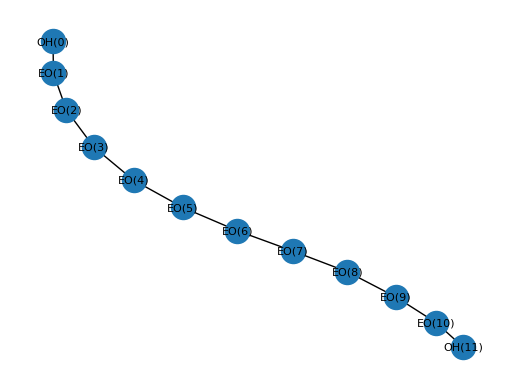

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

bonds = list(topology.bonds())

G = nx.Graph()
for atom in topology.atoms():
    G.add_node(atom.index, label=atom.name, residue=atom.residue.name)

for bond in bonds:
    a1 = bond[0].index
    a2 = bond[1].index
    G.add_edge(a1, a2)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
labels = {i: f"{G.nodes[i]['label']}({i})" for i in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.axis("off")
plt.show()


In [4]:
topology, positions = builder.replicate_model(topology, positions, nx=3, ny=3, nz=3)

In [6]:
param_dict = {
    "BOND": {
        ("EO", "EO"): {"r0": 0.5, "k": 100},
        ("EO", "OH"): {"r0": 0.45, "k": 120},
    },
    "NONBONDED": {
        "EO": {"sigma": 0.3, "epsilon": 0.5, "charge": 0.0, "mass": 72.0},
        "OH": {"sigma": 0.25, "epsilon": 0.4, "charge": -0.2, "mass": 18.0},
    },
    "ANGLE": {},
    "TORSION": {},
}
ff = CGForceField.from_dict(param_dict)
system = ff.create_system(topology)

In [7]:
import sys

import openmm
import openmm.app as app
from openmm import unit

temperature = 300 * unit.kelvin
friction = 1 / unit.picosecond
timestep = 0.001 * unit.picoseconds
integrator = openmm.LangevinIntegrator(temperature, friction, timestep)

simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.reporters.append(app.PDBReporter("example-traj.pdb", 1000))
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        1000,
        step=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
        volume=True,
        density=True,
    )
)
simulation.minimizeEnergy()
simulation.step(10_000)


#"Step","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
1000,2893.1588635166927,970.0521994870539,240.06268013721044,8.0,4.23686542989407
2000,3002.915150796418,1229.4568474913046,304.2585812164298,8.0,4.23686542989407
3000,3010.196222582285,1246.0546585329223,308.3661076002354,8.0,4.23686542989407
4000,2949.862595104568,1257.6293136635977,311.2305335907163,8.0,4.23686542989407
5000,2844.6242024845496,1341.9503639239902,332.09779962876866,8.0,4.23686542989407
6000,2805.414718642576,1320.289319025789,326.7372546028574,8.0,4.23686542989407
7000,2844.4960555993757,1255.21383933548,310.63276654135836,8.0,4.23686542989407
8000,2714.790836363527,1187.5387940037133,293.8849536202167,8.0,4.23686542989407
9000,2687.2304728018617,1221.2548673756369,302.2288045404525,8.0,4.23686542989407
10000,2763.5780089886775,1192.6282100072553,295.1444516624763,8.0,4.23686542989407
